In [1]:
#JSMA
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
from tools import show_images_diff

In [2]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="../picture/horse.jpeg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = Variable(torch.from_numpy(img).to(device).float())
#print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

orig_label=np.argmax(model(img).data.cpu().numpy())
print("orig_label={}".format(orig_label))

#print(img.data.cpu().numpy())

#print(img.data.cpu().numpy().min(3))


orig_label=708


In [3]:
#实现saliency_map
def saliency_map(F, x,t, mask):
        
        # pixel influence on target class
        F[0, t].backward(retain_graph=True)
        derivative=x.grad.data.cpu().numpy().copy()
        alphas = derivative * mask

        # pixel influence on sum of residual classes
        betas = -np.ones_like(alphas)
        
        sal_map = np.abs(alphas) * np.abs(betas) * np.sign(alphas * betas)
        # find optimal pixel & direction of perturbation
        idx = np.argmin(sal_map)
        
        #转换成(p1,p2)格式      
        idx = np.unravel_index(idx, mask.shape)
        pix_sign = np.sign(alphas)[idx]
    
        return idx, pix_sign


In [4]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False

epochs=500
#扰动系数
theta=0.3


#攻击目标
target_label=288
target=Variable(torch.Tensor([float(target_label)]).to(device).long())

loss_func = torch.nn.CrossEntropyLoss()


# the mask defines the search domain
# each modified pixel with border value is set to zero in mask
mask = np.ones_like(img.data.cpu().numpy())

#定义边界
max_=3.0
min_=-3.0

for epoch in range(epochs):
    
    # forward 
    output = model(img)
    
    label=np.argmax(output.data.cpu().numpy())
    loss = loss_func(output, target)
    print("epoch={} label={} loss={}".format(epoch,label,loss))
    
    #如果定向攻击成功
    if label == target_label:
        break
   
    #梯度清零
    zero_gradients(img)

    idx, pix_sign=saliency_map(output, img,target_label, mask)
       
    # apply perturbation 
    img.data[idx]=img.data[idx]+pix_sign * theta * (max_ - min_) 
    
    #达到极限的点不再参与更新
    if (img.data[idx]<=min_) or (img.data[idx]>=max_):
        print("idx={} over {}".format(idx,img.data[idx]))
        mask[idx]=0
        img.data[idx]=np.clip(img.data[idx], min_, max_)

epoch=0 label=708 loss=11.859809875488281
epoch=1 label=708 loss=11.703825950622559
epoch=2 label=708 loss=11.588770866394043
epoch=3 label=708 loss=11.450746536254883
idx=(0, 1, 91, 81) over 4.7505598068237305
epoch=4 label=708 loss=11.446036338806152
epoch=5 label=708 loss=11.295724868774414
epoch=6 label=708 loss=11.207159996032715
idx=(0, 1, 91, 82) over 4.6980390548706055
epoch=7 label=708 loss=11.198644638061523
idx=(0, 1, 92, 82) over 3.038095235824585
epoch=8 label=708 loss=11.088712692260742
epoch=9 label=708 loss=10.945143699645996
epoch=10 label=708 loss=10.788273811340332
idx=(0, 1, 68, 111) over 4.64229679107666
epoch=11 label=708 loss=10.774971961975098
epoch=12 label=708 loss=10.642881393432617
epoch=13 label=708 loss=10.494661331176758
idx=(0, 1, 91, 83) over 4.242856979370117
epoch=14 label=708 loss=10.457512855529785
epoch=15 label=708 loss=10.316808700561523
epoch=16 label=708 loss=10.23098373413086
epoch=17 label=708 loss=10.227466583251953
epoch=18 label=708 loss=1

(3, 224, 224)
l0=(106,) l2=1428.7942469089103


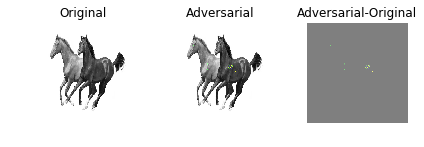

In [5]:

adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean

adv = adv * 256.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

show_images_diff(orig,orig_label,adv,target_label)